# Brickstudy Onboarding first week

## Onboarding assignment : Spark


In [12]:
# ?? 내 vscode에서 작업하면 안되는건가? 꼭 chrome > jupyter lab 에서(웹에서) 해야하는거야?
from pyspark.sql import SparkSession

# Create spark session   # spark session instance 구성 및 생성 # set spark application name, we can identify by name
spark = SparkSession.builder \
    .appName("OnboardingHomework_C") \
    .getOrCreate()


# Read csv file
coupon_df = spark.read.csv("coupon_detail_train.csv", header=True, inferSchema=True)
user_df = spark.read.csv("user_list.csv", header=True, inferSchema=True)


In [13]:
# print each dataframe
coupon_df.head()

Row(ITEM_COUNT=1, I_DATE=datetime.datetime(2012, 3, 28, 15, 6, 6), SMALL_AREA_NAME='兵庫', PURCHASEID_hash='c820a8882374a4e472f0984a8825893f', USER_ID_hash='d9dca3cb44bab12ba313eaa681f663eb', COUPON_ID_hash='34c48f84026e08355dc3bd19b427f09a')

In [14]:
user_df.head()

Row(REG_DATE=datetime.datetime(2012, 3, 28, 14, 14, 18), SEX_ID='f', AGE=25, WITHDRAW_DATE='NA', PREF_NAME=None, USER_ID_hash='d9dca3cb44bab12ba313eaa681f663eb')

## 김철수팀 ETL
| 요청 사항 :                                                                                                                                    |
| ------------------------------------------------------------------------------------------------------------------------------------------ |
| 1. user_list, coupon_detail_train 데이터를 "USER_ID_hash" 기준으로 user_list로 inner join                                                           |
| 2. "REG_DATE" 기준으로 "yyyy-MM-dd" 형식의 date 열 만들기                                                                                             |
| 3. 필요한 열 선택 / ETL 처리                                                                                                                       |
| 4. 결측치 처리                                                                                                                                  |
| - 구분열 결측치 "-"으로, 수치열 결측치 0 으로 처리                                                                                                           |
| - "NA"로 된 값도 위에 정의한 값으로 결측치 처리                                                                                                             |
| 5. date 컬럼을 활용해 year / month / day / dow / weeks 열 만들기                                                                                     |
| - dow의 경우 일요일이 0, 토요일이 6으로 나타나도록                                                                                                           |
| 6. 구분열 기준 수치열 합으로 중복 제거                                                                                                                    |

In [17]:
# 컬럼 이름 출력
print("Columns in coupon_df:", coupon_df.columns)
print("Columns in user_df:", user_df.columns)

Columns in coupon_df: ['ITEM_COUNT', 'I_DATE', 'SMALL_AREA_NAME', 'PURCHASEID_hash', 'USER_ID_hash', 'COUPON_ID_hash']
Columns in user_df: ['REG_DATE', 'SEX_ID', 'AGE', 'WITHDRAW_DATE', 'PREF_NAME', 'USER_ID_hash']


### 1. user_list, coupon_detail_train 데이터를 "USER_ID_hash" 기준으로 user_list로 inner join
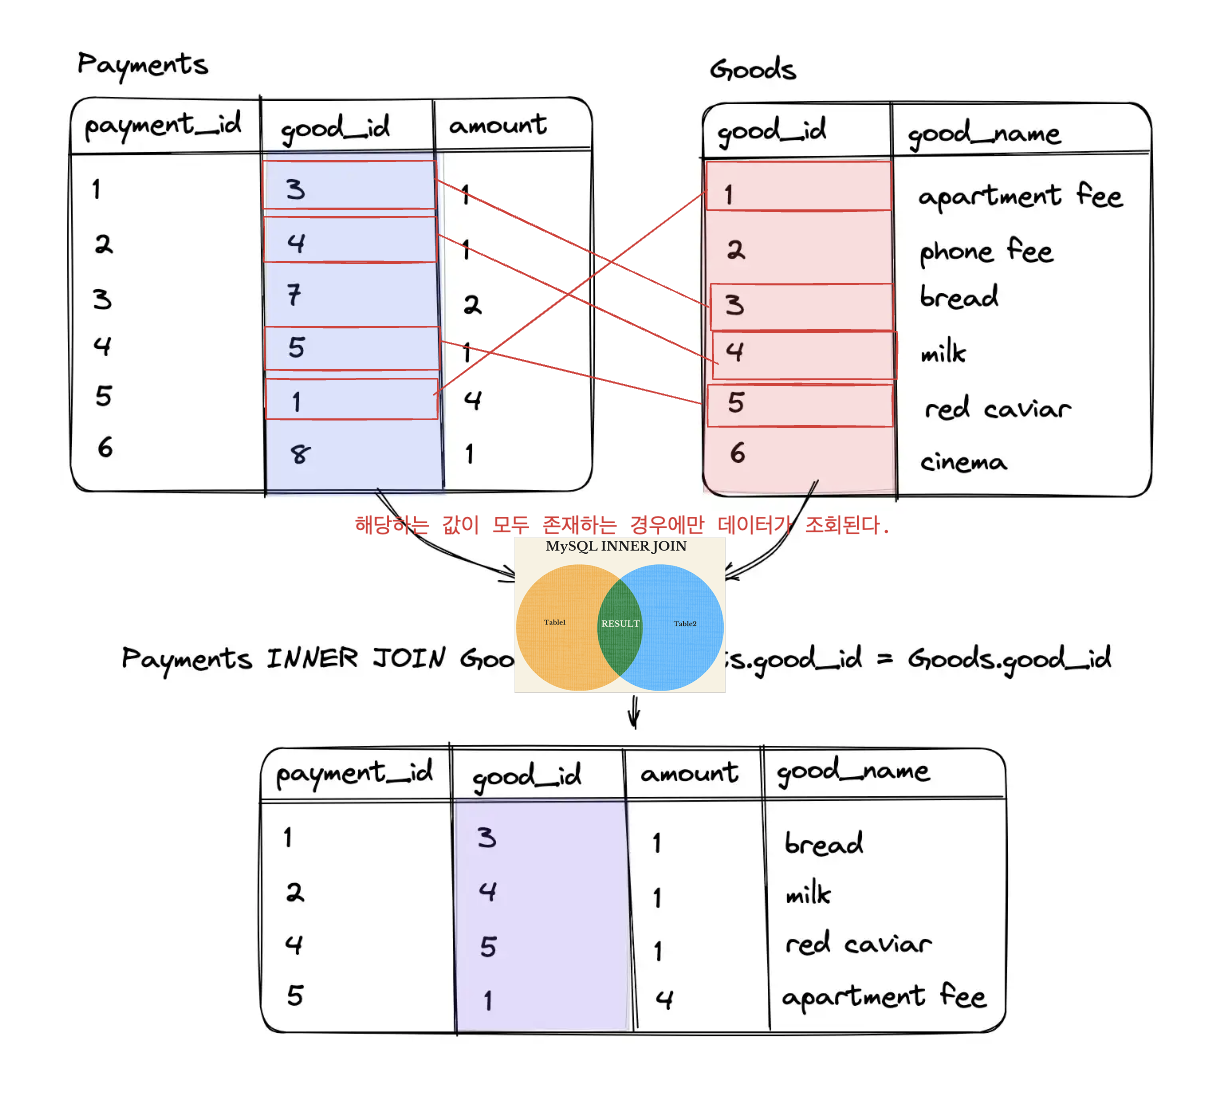

In [16]:
# Join 데이터프레임
joined_df = user_df.join(coupon_df, on="USER_ID_hash", how="inner")

# 결과 출력
joined_df.show()

+--------------------+-------------------+------+---+-------------+---------+----------+-------------------+----------------------------+--------------------+--------------------+
|        USER_ID_hash|           REG_DATE|SEX_ID|AGE|WITHDRAW_DATE|PREF_NAME|ITEM_COUNT|             I_DATE|             SMALL_AREA_NAME|     PURCHASEID_hash|      COUPON_ID_hash|
+--------------------+-------------------+------+---+-------------+---------+----------+-------------------+----------------------------+--------------------+--------------------+
|d9dca3cb44bab12ba...|2012-03-28 14:14:18|     f| 25|           NA|     NULL|         1|2012-03-28 15:06:06|                        兵庫|c820a8882374a4e47...|34c48f84026e08355...|
|560574a339f1b25e5...|2011-05-18 00:41:48|     f| 34|           NA|   東京都|         1|2011-07-04 23:52:54|      銀座・新橋・東京・上野|1b4eb2435421ede98...|767673b7a777854a9...|
|560574a339f1b25e5...|2011-05-18 00:41:48|     f| 34|           NA|   東京都|         1|2011-07-16 00:52:49|          恵

### 2. "REG_DATE" 기준으로 "yyyy-MM-dd" 형식의 date 열 만들기
- col() 함수는 DataFrame의 특정 컬럼을 참조하기 위해 사용됩니다.
- to_date() PySpark에서 문자열 형식의 날짜를 실제 날짜 데이터 타입으로 변환하는 데 사용됩니다
- withColumn() 기존 DataFrame의 컬럼을 수정하거나 새로운 컬럼을 추가하는 데 사용

In [19]:
from pyspark.sql.functions import to_date, col

# "REG_DATE" 기준으로 "yyyy-MM-dd" 형식의 date 열 생성
joined_df_date = joined_df.withColumn("date", to_date(col("REG_DATE"), "yyyy-MM-dd"))

# 결과 출력
joined_df_date.show()

+--------------------+-------------------+------+---+-------------+---------+----------+-------------------+----------------------------+--------------------+--------------------+----------+
|        USER_ID_hash|           REG_DATE|SEX_ID|AGE|WITHDRAW_DATE|PREF_NAME|ITEM_COUNT|             I_DATE|             SMALL_AREA_NAME|     PURCHASEID_hash|      COUPON_ID_hash|      date|
+--------------------+-------------------+------+---+-------------+---------+----------+-------------------+----------------------------+--------------------+--------------------+----------+
|d9dca3cb44bab12ba...|2012-03-28 14:14:18|     f| 25|           NA|     NULL|         1|2012-03-28 15:06:06|                        兵庫|c820a8882374a4e47...|34c48f84026e08355...|2012-03-28|
|560574a339f1b25e5...|2011-05-18 00:41:48|     f| 34|           NA|   東京都|         1|2011-07-04 23:52:54|      銀座・新橋・東京・上野|1b4eb2435421ede98...|767673b7a777854a9...|2011-05-18|
|560574a339f1b25e5...|2011-05-18 00:41:48|     f| 34|        

### 필요한 열 선택 / ETL 처리 ??
- alias : 별칭 설정 (이름 변경)
- select : 선택된 컬럼을 새로운 DataFrame으로 반환합니다.

필요한 열은 마지막에 요구한 date, user_id, sex_id, name, area_name, purchased_id, item_count

In [21]:
selected_df = joined_df_date.select(
    col("date"),
    col("USER_ID_hash").alias("user_id"),
    col("SEX_ID").alias("sex_id"),
    col("PREF_NAME").alias("name"),
    col("SMALL_AREA_NAME").alias("area_name"),
    col("PURCHASEID_hash").alias("purchased_id"),
    col("ITEM_COUNT").alias("item_count")
)
selected_df.show()

+----------+--------------------+------+------+----------------------------+--------------------+----------+
|      date|             user_id|sex_id|  name|                   area_name|        purchased_id|item_count|
+----------+--------------------+------+------+----------------------------+--------------------+----------+
|2012-03-28|d9dca3cb44bab12ba...|     f|  NULL|                        兵庫|c820a8882374a4e47...|         1|
|2011-05-18|560574a339f1b25e5...|     f|東京都|      銀座・新橋・東京・上野|1b4eb2435421ede98...|         1|
|2011-05-18|560574a339f1b25e5...|     f|東京都|          恵比寿・目黒・品川|36b5f9ba46c44b655...|         1|
|2011-05-18|560574a339f1b25e5...|     f|東京都|          恵比寿・目黒・品川|2f30f46937cc90047...|         1|
|2011-05-18|560574a339f1b25e5...|     f|東京都|          恵比寿・目黒・品川|4d000c64a55ac573d...|         1|
|2011-05-18|560574a339f1b25e5...|     f|東京都|          恵比寿・目黒・品川|d8b030c8a4a2c1051...|         1|
|2011-05-18|560574a339f1b25e5...|     f|東京都|          恵比寿・目黒・品川|2c98138766edf5d5b..

### 4. 결측치 처리
- 구분열 결측치 "-"으로, 수치열 결측치 0 으로 처리 
- "NA"로 된 값도 위에 정의한 값으로 결측치 처리

"name" 컬럼에서 결측치들이 있으므로 먼저 Name 컬럼의 결측치들을 확인한다.
- filter() : 특정 조건에 맞는 행을 필터링

In [30]:
print(selected_df.filter(selected_df["name"].isNull()).count())
selected_df.filter(selected_df["name"].isNull()).show()

37156
+----------+--------------------+------+----+----------------------------+--------------------+----------+
|      date|             user_id|sex_id|name|                   area_name|        purchased_id|item_count|
+----------+--------------------+------+----+----------------------------+--------------------+----------+
|2012-03-28|d9dca3cb44bab12ba...|     f|NULL|                        兵庫|c820a8882374a4e47...|         1|
|2012-02-08|43fc18f32eafb0571...|     m|NULL|                        山形|d88f6ab0f9b8d737c...|         1|
|2012-02-08|43fc18f32eafb0571...|     m|NULL|新宿・高田馬場・中野・吉祥寺|1cef71947aa1f80e7...|         1|
|2012-02-08|43fc18f32eafb0571...|     m|NULL|新宿・高田馬場・中野・吉祥寺|e47445e2f58d7e9c0...|         1|
|2012-02-08|43fc18f32eafb0571...|     m|NULL|新宿・高田馬場・中野・吉祥寺|0325b7df2461cc47c...|         1|
|2011-12-27|72f88db98f71be3f5...|     m|NULL|                      北海道|422c3e8172836560b...|         1|
|2011-12-27|72f88db98f71be3f5...|     m|NULL|新宿・高田馬場・中野・吉祥寺|8dd554e0e649cff7f...

In [31]:
#37156개의 Null 값을 '-'로 처리
df_filled = selected_df.na.fill({"name": "-"})
df_filled.filter(selected_df["name"].isNull()).show()

+----------+--------------------+------+----+----------------------------+--------------------+----------+
|      date|             user_id|sex_id|name|                   area_name|        purchased_id|item_count|
+----------+--------------------+------+----+----------------------------+--------------------+----------+
|2012-03-28|d9dca3cb44bab12ba...|     f|   -|                        兵庫|c820a8882374a4e47...|         1|
|2012-02-08|43fc18f32eafb0571...|     m|   -|                        山形|d88f6ab0f9b8d737c...|         1|
|2012-02-08|43fc18f32eafb0571...|     m|   -|新宿・高田馬場・中野・吉祥寺|1cef71947aa1f80e7...|         1|
|2012-02-08|43fc18f32eafb0571...|     m|   -|新宿・高田馬場・中野・吉祥寺|e47445e2f58d7e9c0...|         1|
|2012-02-08|43fc18f32eafb0571...|     m|   -|新宿・高田馬場・中野・吉祥寺|0325b7df2461cc47c...|         1|
|2011-12-27|72f88db98f71be3f5...|     m|   -|                      北海道|422c3e8172836560b...|         1|
|2011-12-27|72f88db98f71be3f5...|     m|   -|新宿・高田馬場・中野・吉祥寺|8dd554e0e649cff7f...|     

In [40]:
# 나머지 컬럼도 Null 값 유무 확인
for col in df_filled.columns:
    df_filled.filter(df_filled[col].isNull()).show()

+----+-------+------+----+---------+------------+----------+
|date|user_id|sex_id|name|area_name|purchased_id|item_count|
+----+-------+------+----+---------+------------+----------+
+----+-------+------+----+---------+------------+----------+

+----+-------+------+----+---------+------------+----------+
|date|user_id|sex_id|name|area_name|purchased_id|item_count|
+----+-------+------+----+---------+------------+----------+
+----+-------+------+----+---------+------------+----------+

+----+-------+------+----+---------+------------+----------+
|date|user_id|sex_id|name|area_name|purchased_id|item_count|
+----+-------+------+----+---------+------------+----------+
+----+-------+------+----+---------+------------+----------+

+----+-------+------+----+---------+------------+----------+
|date|user_id|sex_id|name|area_name|purchased_id|item_count|
+----+-------+------+----+---------+------------+----------+
+----+-------+------+----+---------+------------+----------+

+----+-------+------

In [44]:
# item_count 값이 ""인 값 확인 
df_filled.filter(df_filled["item_count"]==0).count()

0

In [48]:
# 모든 문자열 컬럼에 대해 trim 적용
for column in df_filled.columns:
    if df_filled.schema[column].dataType == "string":
        df_filled = df_filled.withColumn(column, trim(col(column)))
df_filled.show(truncate=False)

+----------+--------------------------------+------+------+----------------------------+--------------------------------+----------+
|date      |user_id                         |sex_id|name  |area_name                   |purchased_id                    |item_count|
+----------+--------------------------------+------+------+----------------------------+--------------------------------+----------+
|2012-03-28|d9dca3cb44bab12ba313eaa681f663eb|f     |-     |兵庫                        |c820a8882374a4e472f0984a8825893f|1         |
|2011-05-18|560574a339f1b25e57b0221e486907ed|f     |東京都|銀座・新橋・東京・上野      |1b4eb2435421ede98c8931c42e8220ec|1         |
|2011-05-18|560574a339f1b25e57b0221e486907ed|f     |東京都|恵比寿・目黒・品川          |36b5f9ba46c44b65587d0b16f2e4c77f|1         |
|2011-05-18|560574a339f1b25e57b0221e486907ed|f     |東京都|恵比寿・目黒・品川          |2f30f46937cc9004774e576914b2aa1a|1         |
|2011-05-18|560574a339f1b25e57b0221e486907ed|f     |東京都|恵比寿・目黒・品川          |4d000c64a55ac573d0ae1a8f03677f50|

### 5. date 칼럼을 활용해 year / month / day / dow / weeks 열 만들기 
- dow의 경우 일요일이 0, 토요일이 6으로 나타나도록한다.

In [45]:
from pyspark.sql.functions import col, year, month, dayofmonth, dayofweek, weekofyear

df_date_trans = df_filled.withColumn("year", year(col("date"))) \
       .withColumn("month", month(col("date"))) \
       .withColumn("day", dayofmonth(col("date"))) \
       .withColumn("dow", (dayofweek(col("date")) + 5) % 7) \
       .withColumn("weeks", weekofyear(col("date")))

# 결과 출력
df_date_trans.show()

+----------+--------------------+------+------+----------------------------+--------------------+----------+----+-----+---+---+-----+
|      date|             user_id|sex_id|  name|                   area_name|        purchased_id|item_count|year|month|day|dow|weeks|
+----------+--------------------+------+------+----------------------------+--------------------+----------+----+-----+---+---+-----+
|2012-03-28|d9dca3cb44bab12ba...|     f|     -|                        兵庫|c820a8882374a4e47...|         1|2012|    3| 28|  2|   13|
|2011-05-18|560574a339f1b25e5...|     f|東京都|      銀座・新橋・東京・上野|1b4eb2435421ede98...|         1|2011|    5| 18|  2|   20|
|2011-05-18|560574a339f1b25e5...|     f|東京都|          恵比寿・目黒・品川|36b5f9ba46c44b655...|         1|2011|    5| 18|  2|   20|
|2011-05-18|560574a339f1b25e5...|     f|東京都|          恵比寿・目黒・品川|2f30f46937cc90047...|         1|2011|    5| 18|  2|   20|
|2011-05-18|560574a339f1b25e5...|     f|東京都|          恵比寿・目黒・品川|4d000c64a55ac573d...|         1|2011| 

### 6. 구분열 기준 수치열 합으로 중복 제거
- 현재 수치열은 "item_count"지만, 최종 요청사항에 cost, cost_Vat도 포함이므로 cost, cost_vat을 먼저 생성한 후에 구분열 기준 수치열 합 진행
- cost = item_count * 8000
- cost_VAT = cost * 1.1

In [53]:
df_add_cost = df_date_trans.withColumn("cost", col("item_count") * 8000) \
                           .withColumn("cost_VAT", col("cost") * 1.1)

df_add_cost.show()

+----------+--------------------+------+------+----------------------------+--------------------+----------+----+-----+---+---+-----+-----+--------+
|      date|             user_id|sex_id|  name|                   area_name|        purchased_id|item_count|year|month|day|dow|weeks| cost|cost_VAT|
+----------+--------------------+------+------+----------------------------+--------------------+----------+----+-----+---+---+-----+-----+--------+
|2012-03-28|d9dca3cb44bab12ba...|     f|     -|                        兵庫|c820a8882374a4e47...|         1|2012|    3| 28|  2|   13| 8000|  8800.0|
|2011-05-18|560574a339f1b25e5...|     f|東京都|      銀座・新橋・東京・上野|1b4eb2435421ede98...|         1|2011|    5| 18|  2|   20| 8000|  8800.0|
|2011-05-18|560574a339f1b25e5...|     f|東京都|          恵比寿・目黒・品川|36b5f9ba46c44b655...|         1|2011|    5| 18|  2|   20| 8000|  8800.0|
|2011-05-18|560574a339f1b25e5...|     f|東京都|          恵比寿・目黒・品川|2f30f46937cc90047...|         1|2011|    5| 18|  2|   20| 8000|  8800.

In [54]:
df_add_cost.printSchema()

root
 |-- date: date (nullable = true)
 |-- user_id: string (nullable = true)
 |-- sex_id: string (nullable = true)
 |-- name: string (nullable = false)
 |-- area_name: string (nullable = true)
 |-- purchased_id: string (nullable = true)
 |-- item_count: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dow: integer (nullable = true)
 |-- weeks: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- cost_VAT: double (nullable = true)



In [78]:
# item count와 cost, cost_VAT를 수치열로 설정, user_id를 구분열로 설정하여 구분열 기준 수치열 합으로 중복 제거
# user_id를 기준으로 중복 제거 및 수치형 컬럼 합 계산
from pyspark.sql.functions import sum

df_grouped_ = df_add_cost.groupBy("user_id").agg(
    sum("item_count").alias("item_count"),
    sum("cost").alias("cost"),
    sum("cost_VAT").alias("cost_VAT")
)

# 결과 출력
df_grouped_.show()

+--------------------+----------+------+--------+
|             user_id|item_count|  cost|cost_VAT|
+--------------------+----------+------+--------+
|e8d2e69683bd9862f...|         7| 56000| 61600.0|
|6c6074e3931a7716a...|        15|120000|132000.0|
|928d507094eec19db...|         2| 16000| 17600.0|
|c4d8e7614941980ac...|         3| 24000| 26400.0|
|a492dee705399bd02...|         1|  8000|  8800.0|
|292dea6ccabb2a000...|         1|  8000|  8800.0|
|d00694194e2295118...|         3| 24000| 26400.0|
|8e51b5e6221f6935e...|         3| 24000| 26400.0|
|9178af3f1e030a5db...|         5| 40000| 44000.0|
|96f16ea36c3c93332...|         6| 48000| 52800.0|
|3b7410bb25cff139d...|         2| 16000| 17600.0|
|9d3406191391fb7cd...|         2| 16000| 17600.0|
|4a3d0a2b28ace353f...|        89|712000|783200.0|
|42f262737c66d7794...|        47|376000|413600.0|
|f933a2fb10bc2a5c9...|        21|168000|184800.0|
|4b2c695e963ccb452...|         3| 24000| 26400.0|
|f8ac4815e6eb8e741...|        11| 88000| 96800.0|


구분열을 모두 해야 요구한 데이터 프레임이 나옴 ㅎㅎ

In [79]:
from pyspark.sql.functions import sum

id_col = ["date", "year", "month", "day", "dow", "weeks", "user_id", "sex_id", "name", "area_name", "purchased_id"]

df_grouped = df_add_cost.groupBy(id_col).agg(
    sum("item_count").alias("item_count"),
    sum("cost").alias("cost"),
    sum("cost_VAT").alias("cost_VAT")
)

# 결과 출력
df_grouped.show()

+----------+----+-----+---+---+-----+--------------------+------+--------+----------------------------+--------------------+----------+-----+------------------+
|      date|year|month|day|dow|weeks|             user_id|sex_id|    name|                   area_name|        purchased_id|item_count| cost|          cost_VAT|
+----------+----+-----+---+---+-----+--------------------+------+--------+----------------------------+--------------------+----------+-----+------------------+
|2010-11-07|2010|   11|  7|  6|   44|33169dce4386f3c08...|     f|  奈良県|                        滋賀|a1d78dfa26572652f...|         3|24000|26400.000000000004|
|2012-05-20|2012|    5| 20|  6|   20|27ab20d45e00d51f4...|     f|  埼玉県|          恵比寿・目黒・品川|93b1c849b22df546f...|         2|16000|           17600.0|
|2010-10-15|2010|   10| 15|  4|   41|8d4e54014056aa384...|     m|  東京都|新宿・高田馬場・中野・吉祥寺|1204ac424b6e5f444...|         1| 8000|            8800.0|
|2011-12-31|2011|   12| 31|  5|   52|0b49f9c82fc72353f...|     f|  京

In [81]:
output_path = "./result"
df_grouped.write.parquet(output_path, mode="overwrite")
# df_grouped.write.parquet(output_path)

In [82]:
saved_df = spark.read.parquet(output_path)
saved_df.show()

+----------+----+-----+---+---+-----+--------------------+------+--------+----------------------------+--------------------+----------+-----+--------+
|      date|year|month|day|dow|weeks|             user_id|sex_id|    name|                   area_name|        purchased_id|item_count| cost|cost_VAT|
+----------+----+-----+---+---+-----+--------------------+------+--------+----------------------------+--------------------+----------+-----+--------+
|2012-01-30|2012|    1| 30|  0|    5|f55c2f67be0321adc...|     f|  千葉県|                        栃木|2779ec028f8a6b0e8...|         1| 8000|  8800.0|
|2011-06-22|2011|    6| 22|  2|   25|b513d24721f5f8628...|     m|神奈川県|                      北海道|29bc62f0ab4e39625...|         1| 8000|  8800.0|
|2011-08-19|2011|    8| 19|  4|   33|7e70f153be05bfebe...|     f|       -|                        茨城|585a54baf0e6a1d9a...|         1| 8000|  8800.0|
|2011-07-26|2011|    7| 26|  1|   30|33fd5dd0c7b2d7c09...|     f|       -|新宿・高田馬場・中野・吉祥寺|80069211d17d9add2..

In [84]:
from pyspark.sql.functions import col, sum, max

# cost_VAT 컬럼의 최댓값 찾기
max_cost_VAT = saved_df.agg(max("cost_VAT")).collect()[0][0]
print(f"The maximum value of cost_VAT is: {max_cost_VAT}")

The maximum value of cost_VAT is: 484000.00000000006


In [85]:
from pyspark.sql.functions import col, sum, max

# cost_VAT 컬럼의 최댓값 찾기
max_cost_VAT = df_grouped.agg(max("cost_VAT")).collect()[0][0]
print(f"The maximum value of cost_VAT is: {max_cost_VAT}")

The maximum value of cost_VAT is: 484000.00000000006


In [86]:
spark.stop()